# 解の求め方と最適化問題

In [1]:
import numpy as np
import scipy.optimize as op
import pandas as pd

## はじめに

線形の方程式の解を求めることは比較的簡単である。１変数の場合は簡単に式を変形できる。変数が複数ある場合でも，[「連立一次方程式の解」の節](sec:2-simultaneousEq)で説明したように，`numpy.linalg`を使えば簡単に解を求めることができる。例えば，[差分方程式と経済分析](chap:7-differenceEq)で扱った45度線モデルと蜘蛛の巣モデルは線形であるため、長期的な均衡の値を簡単に計算することができる。またソロー・モデルも線形ではないが、定常状態の資本ストック（$k_*$）について解くことができるので、長期的な値を計算することが可能である。しかし非線形モデルによっては、長期的均衡の値を簡単に求めることができない場合もあり、その場合に使う手法をここで説明する。

```{margin}
<div name="html-admonition">
Do you want to read in a differnt language? Open the 
<input type="button" onclick="location.href='https://translate.google.com/translate?hl=&sl=ja&tl=en&u='+window.location;" value="Google translated version" style="color:#ffffff;background-color:#008080;" onmouseover="this.style.background='#99ccff'" onmouseout="this.style.background='#008080'"/>
in English or the language of your choice.
</div>
```

コードを書いて非線形の方程式の解を求めるには色々な方法があるり，ここではその代表的な方法の考え方についてまず説明する。その後`SciPy`（「サイパイ」と読み，Scientific Pythonの略）というパッケージにある`optimize`というモジュールを紹介する。`SciPy`は`NumPy`の大幅な拡張版と理解して良いだろう。`SciPy`を読み込むと`NumPy`の関数などを利用できるようになる。しかし`SciPy`は大きなパッケージであり，全てを読み込む必要もない。従って，`NumPy`を読み込んで`SciPy`のサブパッケージや関数を読み込むということで十分であろう。そして`SciPy`のモジュール`optimize`に非線形の方程式の解を簡単に求めることができる関数が含まれている。もちろんこれらの関数は線形の方程式の解を求める為にも使える。また`scipy.optimize`には最適化問題のための関数も用意されており，`Python`で経済学を学ぶ為には必須となるツールと言えるだろう。消費者の効用最大化問題やソロー・モデルの資本の黄金律水準などに応用して使い方を説明する。

## 解の求め方と考え方

### Bisection法

#### 説明

Bisection法の考え方について説明するために，次の関数を考えよう。

$$f(x)=x^3+4x^2-3$$

In [2]:
def f(x):
    return x**3 + 4*x**2 -3

次に３つの変数`a`，`b`，`c`に下の値を割り当てる。

In [3]:
a = -3.0
b = -0.5
c = 0.5*(a+b)

$x$が`a`，`b`，`c`の値を取る場合の$f(x)$の値を計算してみよう。

In [4]:
f(a), f(b), f(c)

(6.0, -2.125, 3.890625)

これらの情報を図示すると次のようになる。

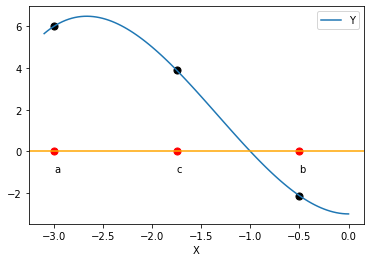

In [5]:
x = np.linspace(-3.1, 0, 100)          # 1

df1 = pd.DataFrame({'X':x, 'Y':f(x)})  # 2

ax = df1.plot('X','Y')     # 3

ax.axhline(0, c='orange')  # 4
ax.text(a,-1,"a")          # 5
ax.text(b,-1,"b")
ax.text(c,-1,"c")
ax.scatter([a,b,c], [f(a), f(b),f(c)], s=50, c='k')  # 6
ax.scatter([a,b,c], [0,0,0], s=50, c='red')
pass

```{admonition} コードの説明
:class: dropdown

1. `-3.1`から`0`から等間隔で`100`の値を生成し横軸に設定する。
2. `x`と`f(x)`の値からなる`DataFrame`の作成。
3. `X`を横軸、`Y`を縦軸に指定し`f(x)`の曲線をプロットする。また図の軸を`ax`とする。
4. `ax`のメソッド`axhline(<横軸の値>)`を使い`ax`に平行線を表示する。`c='orange'`は色を指定する引数。
5. `ax`のメソッド`text(<横軸の値>,<縦軸の値>,<表示する文字>)`を使い`ax`に文字を表示する。
6. `ax`のメソッド`scatter()`を使い`ax`に点を表示する。
    * 第１引数：横軸の値のリスト
    * 第２引数：縦軸の値のリスト
    * 第３引数：点のサイズ
    * 第４引数：点の色
```

＜`bisection`方の考え方＞
* [中間値の定理](https://ja.wikipedia.org/wiki/中間値の定理)に基づく。
* `f(a)`と`f(b)`の符号が異なり`f(x)`が連続関数である場合、`a`と`b`の間には`f(x)`がゼロになる`x`の値が必ず存在する。（一般的には，`f(x)`がゼロになる`x`の値は奇数個存在することになる。）
* 上の図の`c=(a+b)/2`は`a`と`b`の平均値であり、次の３つの可能性がある。
    1. `f(c)=0`
        * この場合は解が求められたことになる。
    1. `f(c)>0`
        * （上の図のように）`f(c)`と`f(a)`が同じ符号であるため、次は`c`と`b`の間で同様の計算をおこなう。例えば，`d=(c+b)/2`を計算する。
    1. `f(c)<0`
        * （上の図とは異なるが）`f(c)`と`f(a)`は異なる符号であるため、次は`a`と`c`の間で同様の計算をおこなう。例えば，`d=(a+c)/2`を計算する。
* このように`f(x)=0`となる`x`を「挟み撃ち」するように計算プロセスを続けると`f(x)=0`を満たす`x`の値に十分に近い値を求めることができる。

＜注意点＞
* 計算には`a`と`b`のように１つの根を挟む２点が必要となる。
* 挟んだ根だけを求めることになる。
* 求めた値は近似となる。
* 求めた値は収束値なので収束する速度が一つの「壁」になり得る。

#### 手計算

実際にコードを書き，Bisection法の考え理解しよう。次の関数を定義する。

In [6]:
def my_bisect(f,a,b,N):
    """ [a,b]におけるf(x)=0の近似解（bisection法）   # 1
    
    引数
    ----------
    f : f(x)=0の連続関数
    a,b : 根を挟む初期の値
    N : 中間値を計算するプロセスの回数

    返り値
    -------
    N回ループ後の解の近似値
    * f(a)*f(b) >= 0 の場合、メッセージが返される。
    * c=(a+b)/2とし、f(a)、f(b)、f(c)が同じ符号の場合、メッセージが返される。
    """
    
    if f(a)*f(b) >= 0:       # 2
        print("f(a)とf(b)は同じ符号です。a、bの値を変えてください。")
        return None
    
    a_ = a                   # 3
    b_ = b                   # 4
    
    for n in range(N):       # 5
        
        c_ = (a_ + b_)/2     # 6
        fc = f(c_)           # 7
        
        if f(a_)*fc < 0:     # 8
            b_ = c_
            
        elif f(b_)*fc < 0:   # 9
            a_ = c_
            
        elif fc == 0:        # 10
            print("正確な根が求められました。")
            return c_
        
        else:                # 11
            print("計算に失敗しました。")
            return None
        
    print(f'{N}回ループ後の値です。')
        
    return (a_ + b_)/2       # 12

```{admonition} コードの説明
:class: dropdown

1. `"""`と`"""`で挟んだ領域は`docstring`と呼ばれ、関数の説明をする。書かなくても良いが、自分が忘れた頃に関数のコードを読むことになるかもしれないので、書く方がオススメ。
2. `f(a)`と`f(b)`の符号が同じ場合は計算を中止する。
3. `bisection`法では根を挟む２つの変数が必要だが、計算を繰り返す毎に両変数がアップデートされる。そのアップデート用の変数として`a_`と`b_`の初期値を`a`と`b`に設定している。
4. (3)を参照。
5. `N`回の`for`ループとして中間値を計算する。
6. 中間値を計算して変数`c_`に割り当てる。
7. 中間値での関数の値を変数`fc`に割り当てる。
8. 中間値と`a_`での関数の符号が異なる場合、`c_`を`b_`に割り当てる（アップデートする）。（`a_`は以前と同じ値。）
9. 中間値と`b_`での関数の符号が異なる場合、`c_`を`a_`に割り当てる（アップデートする）。（`b_`は以前と同じ値。）
10. 中間値である`c_`での関数の値が`0`の場合、近似ではなく正確な根が求められることになる。その旨を立てるメッセージを表示し，`c_`の値を返す。
11. その他の場合は計算の失敗となる。その旨のメッセージを表示し，`None`を返す。
12. `N`回のループ終了後に`a_`と`b_`の中間値として根の近似値が返される。
```

次の例を使って実際に計算してみよう。

In [7]:
def f_ex1(x):
    return x**2 - 2

`f_ex1`には次の正と負の２つの解が存在する。

In [8]:
np.sqrt(2), -np.sqrt(2)

(1.4142135623730951, -1.4142135623730951)

まず$x>0$の解を計算してみよう。

In [9]:
my_bisect(f_ex1, 0, 2, 10)

10回ループ後の値です。


1.4150390625

次に$x<0$の解をしてみる。

In [10]:
my_bisect(f_ex1, -2, 0, 10)

10回ループ後の値です。


-1.4150390625

`N`の値が変わると根の近似値がどう変化するか試してみよう。

次の場合は計算に失敗する。

In [11]:
my_bisect(f_ex1, -2, 2, 10)

f(a)とf(b)は同じ符号です。a、bの値を変えてください。


#### `Scipy`の関数

上で考えた`my_bisect()`関数は，解法の考えを理解するために使ったが，実際にBisection法を使う場合は，`SciPy`パッケージの`optimize`モジュールに用意されている`bisect()`関数を使おう。基本的な考えは同じであり，`my_bisect()`より格段に洗練された関数と考えれば良いだろう。またBisection法だけではなく他にも様々な方法があり，その一つであるBrent法に基づく関数もここで紹介することにする。

##### `bisect`関数 

使い方は、上で定義した`my_bisect`関数と基本的に同じであり、近似値が十分に近い数値になるように`for`ループ回数の引数`N`は自動で決定される。

```
bisect(f, a, b)
```
* `f`：評価の対象となる関数名
* `a`：解探査区間の最小値
* `b`：解探査区間の最大値

In [12]:
op.bisect(f_ex1, 0, 2)

1.4142135623715149

In [13]:
op.bisect(f_ex1, -2, 0)

-1.4142135623715149

##### `brentq`関数

`brentq`関数はBrent法に基づいており、`bisect`関数を拡張した手法（ここでは説明を割愛）である。より安定的により速く解への収束が可能となっている。基本的に使い方は`bisect`と同じである。


```
brentq(f, a, b)
```
* `f`：評価の対象となる関数名
* `a`：解探査区間の最小値
* `b`：解探査区間の最大値

In [14]:
op.brentq(f_ex1, 0, 2)

1.4142135623731364

In [15]:
op.brentq(f_ex1, -2, 0)

-1.4142135623730951

`bisect`と`brentq`のどちらを使っても良いが、`brentq`を使うことを推奨する。

### Newton法

#### 説明

ここではもう一つの解法であるNewton法について説明する。図にある関数`f(x)`を考えよう。$x_1$での傾きは$f^{\prime}(x_1)$であり、次の式が成り立つことが確認できる。

$$
f^{\prime}(x_0)=\dfrac{f(x_0)}{x_0-x_1}
\quad\Rightarrow\quad
x_1 = x_0 - \dfrac{f(x_0)}{f^{\prime}(x_0)}
$$

```{figure} /images/newton.jpeg
---
scale: 30%
name: fig:scipy-newton
---
Newton法
```

即ち、$x_0$が与えられ$f^{\prime}(x_0)$が分かれば、$x_1$を求めることができる。更に、$x_1$が与えられ、$f^{\prime}(x_1)$が分かれば、$x_2$を求めることができる。一般的には次の差分方程式が成り立つことになる。

$$
x_{t+1} = x_t - \dfrac{f(x_t)}{f^{\prime}(x_t)}
$$ (eq:scipy-newton)

この式に従って$x_{t+1}$の計算を続けると、$x_{t+1}$は$f(x)=0$を満たす$x$に漸近的に近づいていき、根に十分に近い値を計算することが可能となる。

＜コメント＞
* 求めた値は近似となる。
* `bisec`関数と`brentq`関数よりも早い率で解に収束する特徴がある。
* `bisec`関数と`brentq`関数と違って、必ず解を求めることができるとは限らない。解探索の`x`の初期値の設定が重要となる。

#### 手計算

Newton法の基本的な考えを説明するために式[](fig:scipy-newton)を捉える関数を定義しよう。

In [16]:
def my_newton(f,Df,x0,N):
    """ Newton法でf(x)=0の根を近似する。

    引数
    ----------
    f : f(x)=0の関数名f
    Df : f(x)の導関数
    x0 : 解探索の初期のxの値
    N : ループの回数

    返り値
    -------
    根の近似値
    Df(x) == 0の場合は None がメッセージが表示される。
    """
    
    x_ = x0              # 1
    
    for n in range(N):   # 2
        
        fx = f(x_)       # 3
        Dfx = Df(x_)     # 4
        
        if Dfx == 0:     # 5
            print('導関数はゼロです。解は見つかりませんでした')
            return None
        
        else:            # 6
            x_ = x_ - fx/Dfx

    print(f'{N}回ループ後の値です。')
    return x_            # 7

```{admonition} コードの説明
:class: dropdown

1. $x$の初期値の設定。また、式[](fig:scipy-newton)の左辺の値$x_{1+t}$は計算を繰り返す毎にアップデートされるが、そのアップデート用の変数として`x_`を使う事になる。
2. `for`ループを`N`回行う。
3. `x_`での関数`f(x)`の値を`fx`に割り当てる。 
4. `x_`での導関数`Df(x)`の値を`Dfx`に割り当てる。 
5. 導関数`Dfx`がゼロになる場合は計算不可能なので，その旨のメッセージを表示し、`None`を返す。
6. 導関数`Dfx`がゼロでなければ、式[](fig:scipy-newton)に従って計算し、`x_`をアップデートする。
7. 近似解`x_`を返す。
```

例として`f_ex(x)`を使うが、まず導関数を定義する。

In [17]:
def Df_ex1(x):
    return 2*x

まず$x>0$の解を求めよう。

In [18]:
my_newton(f_ex1, Df_ex1, 1, 10)

10回ループ後の値です。


1.414213562373095

次に$x<0$の解を求める。

In [19]:
my_newton(f_ex1, Df_ex1, -1, 10)

10回ループ後の値です。


-1.414213562373095

次は計算に失敗するケースとなる。

In [20]:
my_newton(f_ex1, Df_ex1, 0, 10)

導関数はゼロです。解は見つかりませんでした


#### `Scipy`の関数

`Scipy`パッケージの`optimize`モジュールには`newton`法の関数が用意されており、説明で使った手計算の`my_newton()`関数と比べると格段に洗練れている。使い方は簡単で、引数に関数と`x`の初期値を指定するだけであり、近似の誤差とループの回数は自動的に設定される。

```
newton(f, x0)
```
* `f`：評価の対象となる関数名
* `x0`：解探査の初期値

In [21]:
op.newton(f_ex1, 1)

1.414213562373095

In [22]:
op.newton(f_ex1, -1)

-1.414213562373095

またリストとして`x`の初期値を複数設定することも可能である。

In [23]:
op.newton(f_ex1, [1,10])

array([1.41421356, 1.41421356])

これを利用して、複数の根を同時に計算することも可能となる。

In [24]:
op.newton(f_ex1, [-1,1])

array([-1.41421356,  1.41421356])

### マクロ経済学への応用

#### 45度線モデル

ケインズの45度線モデルでは，所得$Y$以外の変数は外生変数として所得が決定されるマクロ経済学の基本的なモデルである。次の記号・仮定を使う。

* 所得：$Y$
* 計画支出：$E=C(Y)+I+G$
* 消費関数：$C(Y)=d+cY^{a}$
    * 自発的消費：$d=10$
    * 限界消費性向：$c=0.7$
    * $\alpha=0.7$
* 投資：$I=15$
* 政府支出：$G=10$
* 均衡：$E=Y$

１つの式でまとめると次式となる。

$$
0= Y -\left(I+G+C(Y)\right)\equiv h_0(Y)
$$

この式をプロットするために，次のパラメータの下での`h0()`関数を定義する。
```
a = 0.5
c = 0.7
d = 10
i = 15
g = 10
```

In [25]:
def h0(y):
    
    a = 0.8
    c = 0.7
    d = 10
    i = 15
    g = 10

    return y - (i + g + d + c*y**a)

プロットしてみよう。

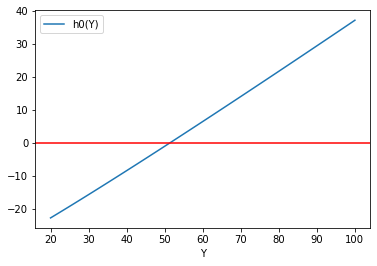

In [26]:
yy = np.linspace(20,100,100)

df1 = pd.DataFrame({'Y':yy, 'h0(Y)':h0(yy)})

ax_ = df1.plot('Y','h0(Y)')
ax_.axhline(0,c='red')
pass

`h0(y)`関数は右上りとなっている。傾きを直感的に説明すると次のようになる。`Y`が増加すると，当たり前だが所得`Y`は線形的に増加する。一方で，計画支出の一部である消費も増加するが，`a`は0.5に設定されているため，増加分は逓減している。したがって，所得と計画支出の差は上昇することになる。

均衡の$Y$を計算してみよう。

＜Bisection法＞

In [27]:
op.bisect(h0, 40, 60)

51.35063858666513

＜Brent法＞

In [28]:
op.brentq(h0, 40, 60)

51.35063858666476

＜Newton法＞

In [29]:
op.newton(h0, 40)

51.35063858666476

#### IS曲線の導出

ここでも45度線モデルを使い財市場の均衡で決定される所得$Y$を考えるが，投資は利子率$r$の非線形の減少関数と仮定する。この仮定により，利子率$r$を所与とした所得の均衡を考えることが可能となり，非線形の$IS$曲線をプロットすることができる。

45度線モデルの投資$I$を次のように変更する。

$$
I = \dfrac{j}{r^{b}}
$$

* $r=$ 実質利子率
* $j=15$
* $b=0.5$

均衡式は次式で与えられる。

$$
0=Y-\left( \dfrac{j}{r^{b}}+G+C(Y) \right)\equiv h_1(Y)
$$

まず関数を再定義するが，$y$と$r$を引数とする。

In [30]:
def h1(y,r):
    
    a = 0.8
    b = 0.5
    c = 0.7
    d = 10
    i = 15
    j = 15
    g = 10

    return y - ( j/r**b + i + g + d + c*y**a )

$r$の複数の値を設定する。

In [31]:
r_arr = np.linspace(0.01, 0.1, 100)

次に`for`ループを使い、財市場での均衡が成立する`r`と`Y`の組み合わせを計算する。

In [32]:
y_list = []

for r in r_arr:
    y = op.newton(h1, 30, args=(r,))    # 1
    y_list.append(y)

df2 = pd.DataFrame({'Y':y_list, 'r':r_arr})

```{admonition} コードの説明
:class: dropdown

1. 関数`h1(y,r)`には`y`と`r`の２つの引数がある。一方、関数`newton()`では`h1()`の第一引数の値を計算することを想定しており，「その他の引数」は`args`で指定する必要がある。この機能を利用することにより、`r`を所与として`h1(y,r)=0`となる`y`の値を計算することが可能となる。`args`を指定する際、タプル`()`で「その他の引数」を指定し、それが１つの場合は`(r,)`のように`,`を付け加える必要がある（基本的にタプルは`,`で定義されるため）。
```

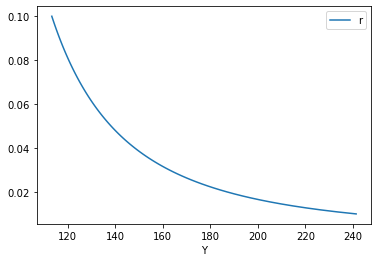

In [33]:
df2.plot('Y','r')
pass

#### ソロー・モデル

モデルの簡単な説明は[「ソロー・モデル」の章](chap:9-solow)を参照してほしい。

* 産出量：$y_t$
* 資本ストック：$k_t$
* 労働：$l_t=1$（労働人口増加率は`0`）
* 貯蓄率：$0<s<1$
* 資本減耗率：$0<d<1$
* 生産性：$A>0$
* 生産関数：$y_t=Ak_t^a$
* 資本の蓄積方程式：
    
    $$
    k_{t+1} = sAk_t^a + (1-d)k_t
    $$
    
* 定常状態での$k_t$：$k_*$
    
    $$
    0 = sAk_*^a + (1-d)k_* - k_* \equiv m(k_*)
    $$
    
パラメターを次の値とする

In [34]:
s = 0.2
a = 0.3
d = 0.1
A = 10

$k$の定常状態$k_*$は次式で定義される。

$$
0 = sAk_*^a + (1-d)k_* - k_{*}
$$ (eq:scipy-kss)

この方程式の解を求めるが，関数`kss()`を定義しよう。

In [35]:
def kss(k):
    return s*A*k**a + (1-d)*k - k

まず式[](eq:scipy-kss)をプロットするが，そのために$k$の値を設定しよう。

In [36]:
k_arr = np.linspace(0,100, 1000)

`for`ループで`kss(k_*)`を計算し、結果を`DataFrame`に格納する。

In [37]:
k_list = []

for k in k_arr:
    k_list.append(kss(k))

df3 = pd.DataFrame({'k':k_arr, 'kss(k)':k_list})

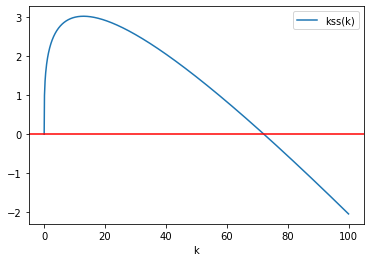

In [38]:
ax_ = df3.plot('k', 'kss(k)')
ax_.axhline(0, c='red')
pass

`scipy.optimize`を使い定常状態$k_*$を計算してみよう。

＜Bisection法＞

In [39]:
op.bisect(kss, 60, 100)

72.21281575281978

＜Brent法＞

In [40]:
op.brentq(kss, 60, 100)

72.21281575282009

＜Newton法＞

In [41]:
op.newton(kss, 60)

72.21281575281984

#### 投資

企業の投資問題を考える。初期投資`fc`を投入すると$T$期間$\pi$の利潤を得るとする。実質利子率は$r$とすると$T$期間の利潤の現在価値の合計は次のようになる。

$$
\int_0^{T}e^{-rt}\pi dt=\frac{\pi}{r}\left(1-e^{-Tr}\right)
$$

パラメータは次の値としよう

In [42]:
r = 0.07
pi = 10
fc = 100

問題：
>「投資の正味現在価値（net present value）がゼロになるにはどれだけ長く事業が続く必要があるか？」

利潤の正味現在価値は

$$
\frac{\pi}{r}\left(1-e^{-Tr}\right)-fc
$$

で与えられる。この式を捉える関数を作成しよう。

In [43]:
def npv(x):
    return (1-np.exp(-x*r))*pi/r - fc

Newton法を使い`npv()`がゼロになる$T$を計算する。

In [44]:
op.newton(npv,10)

17.19961149037052

## 最適化問題：１変数の場合

### 説明

最適化問題は経済学の根幹をなすが、ここでは`scipy.optimize`の`minimize_scalar`関数の使い方を簡単に説明する。様々な引数が用意されているが、基本的には次のようなコードの書き方となる。

1. デフォルトではBrent法が使われる。
    ```
    minimize_scalar(f, bracket=(a,b))
    ```
    * `f`は最小化したい関数名
    * `bracket`は計算の初期値を指定する引数であり、省略可能。初期値を設定する場合は２つ必要である。関数を最小化すると思われる`x`に対して必ずしも`a<x<b`が満たされるように`a`と`b`の値を設定する必要はなく、下で定義する`f_ex2`の例が示すように、必ずしも区間内に解があるとは限らない。
1. Bounded法を使う場合
    ```
    minimize_scalar(f, method='bounded', bounds=(a,b))
    ```
    * `f`：最小化したい関数名
    * `method`：計算手法を指定する引数であり、`bounded`を指定する（デフォルトは`brent`）。
    * `bounds`は関数を最大化する`x`の値を探す区間を指定する引数であり、`a`は区間の最小値、`b`は区間の最大値（裏でBrent法が使われており、関数を最小化する`x`の探索は`bounds`で指定した区間に限られる）

＜２つの注意点＞
1. 返り値は、関数を最小化する変数の値だけではなく、様々な情報が整理されたオブジェクトとして返される。
1. 最大化のための関数は用意されていない。従って、最大化したい関数にマイナスの符号をつけて`minimize_scalar()`関数を評価する必要がある。

### 例１

`f_ex1`関数を例として考えよう。最小化される`x`を計算する。

In [45]:
res1 = op.minimize_scalar(f_ex1)
res1

     fun: -2.0
    nfev: 40
     nit: 36
 success: True
       x: 9.803862664247969e-09

この返り値の中で重要なのは次の３つである。
* `fun`（１行目）：最小化された場合の関数の値
* `success`（最後から２行目）：計算が成功したかどうかを示す。
    * `True`：成功
    * `False`：失敗
* `x`（最後）：関数を最小化する変数の値

それぞれは次のように属性としてアクセスできる。

In [46]:
res1.fun

-2.0

In [47]:
res1.success

True

In [48]:
res1.x

9.803862664247969e-09

### 例２

次に最小値が複数ある場合を考えよう。

In [49]:
def f_ex2(x):
    return x**4 - x**2

まずこの関数を図示しよう。

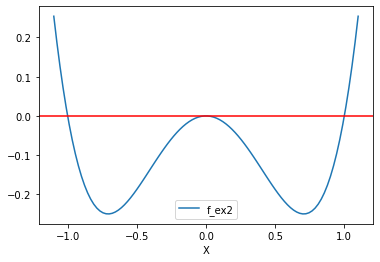

In [50]:
xx = np.linspace(-1.1, 1.1, 100)
df_ex2 = pd.DataFrame({'X':xx, 'f_ex2':f_ex2(xx)})
ax_ = df_ex2.plot('X','f_ex2')
ax_.axhline(0,c='red')
pass

まず`method`のデフォルトである`brent`法を使ってみよう。解が２つあるため、次のコードでは`Python`が選んだ解しか求めることができない。

In [51]:
res2 = op.minimize_scalar(f_ex2)
res2

     fun: -0.24999999999999994
    nfev: 15
     nit: 11
 success: True
       x: 0.7071067853059209

次に引数`bracket`を使ってみよう。

In [52]:
res3 = op.minimize_scalar(f_ex2, bracket=(-1,-0.5))
res3

     fun: -0.24999999999999994
    nfev: 16
     nit: 12
 success: True
       x: -0.7071067842613271

しかし次の２つ例は`bracket`内に必ず解が存在するとは限らないことを示している。

In [53]:
res3 = op.minimize_scalar(f_ex2, bracket=(-1,-0.8))
res3

     fun: -0.25
    nfev: 14
     nit: 10
 success: True
       x: -0.7071067804088556

In [54]:
res3 = op.minimize_scalar(f_ex2, bracket=(-1,-0.1))
res3

     fun: -0.25
    nfev: 16
     nit: 12
 success: True
       x: 0.7071067805303989

「ん？」と思うかもしれないが、`brent`のアルゴリズムがそのようになっているので、その性質を覚えるしかない。

一方、`method='bounded'`を使うと、`bounds`で指定された区間の解が探索される。

In [55]:
res4 = op.minimize_scalar(f_ex2, method='bounded', bounds=(-1,0))
res4

     fun: -0.24999999999998732
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: -0.707106701474177

### ソロー・モデル：黄金律

資本の黄金律水準とは、長期均衡において一人当たり消費を最大化する資本ストックであり、貯蓄率$s$に依存している。それを示すために、まず定常状態の資本ストック$k_*$をパラメータで示すが，次式は式[](eq:scipy-kss)から導出できる。

$$
k_*=\left(
        \frac{As}{d}
    \right)^{\frac{1}{1-a}}
$$

更に、定常状態での一人当たりGDPと消費は次式で与えられる。

$$
y_*=Ak_*^{a}
\quad
c_*=(1-s)y_*
$$

これらを使うと、一人当たり消費を貯蓄率の関数として表すことができる。

$$
c=(1-s)A\left(\frac{As}{d}\right)^{\frac{a}{1-a}}
$$

関数として定義し図示してみよう。

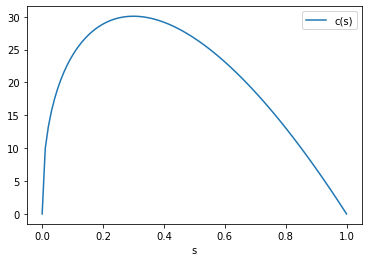

In [56]:
# sの値
s_arr = np.linspace(0,1,100)

# 消費関数
def c(s):
    return (1-s)*A*(A*s/d)**(a/(1-a))

# 消費の値を入れるリスト
c_list = []

# 消費の計算
for s in s_arr:
    c_list.append(c(s))

# DataFrameの作成
df4 = pd.DataFrame({'s':s_arr, 'c(s)':c_list})

# プロット
df4.plot('s','c(s)')
pass

次に一人当たり消費を最大化する貯蓄率を求めるために関数を定義する。

In [57]:
def c_minus(s):
    return -(1-s)*A*(A*s/d)**(a/(1-a))

最大化するためにマイナスの符号が追加されていることに留意しよう。

デフォルトのBrent法を使い消費を最大化する貯蓄率$s$を求める。

In [58]:
op.minimize_scalar(c_minus)

     fun: -30.071147877019232
    nfev: 17
     nit: 13
 success: True
       x: 0.30000000024161544

Bounded法でも同じ解が求められる。

In [59]:
op.minimize_scalar(c_minus, method='bounded', bounds=(0, 1))

     fun: -30.071147877017722
 message: 'Solution found.'
    nfev: 9
  status: 0
 success: True
       x: 0.2999998786598638

### 労働供給問題

ミクロ経済学で学ぶ消費者の労働供給問題を考えよう。消費者は消費財と余暇の２財を消費し，効用を最大化する消費財と余暇を選択すると考える。

変数の定義：
* $u$：効用
* $c$：消費
* $l$：労働供給（24時間のパーセント）
* $p$：消費財の価格
* $w$：賃金
* $1$：24時間を100%として。
* $1-l$：余暇

* 効用関数：
    
    $$u=a\ln(c)+(1-a)\ln(1-l)$$
    
* 制約式：

    $$pc=wl$$ (eq:scipy-pcwl)

制約式のもとで消費者は$c$と$l$を選択し効用を最大化する。

＜解法＞
* 制約式を効用関数に代入する

    $$\max_{l}\;a\ln\left(\frac{wl}{p}\right)+(1-a)\ln(1-l)$$

  これにより効用は$l$の関数になり，`.minimize_scalar()`が使える形になっている。

次の値を仮定する。

In [60]:
a = 0.6
p = 1
w = 10

目的関数（最大化する対象となる関数）を定義する。

In [61]:
def u_minus(l):
    return -( a*np.log(w*l/p)+(1-a)*np.log(1-l) )

効用を最大化する。

In [62]:
res_u = op.minimize_scalar(u_minus, method='bounded', bounds=(0,1))
res_u

     fun: -0.7085393887825051
 message: 'Solution found.'
    nfev: 9
  status: 0
 success: True
       x: 0.5999985035112788

In [63]:
print(f'最適な労働供給は{res_u.x:.2f}である。')

最適な労働供給は0.60である。


予算制約式から消費量は

$$
c=\frac{wl}{p}
$$ (eq:scipy-c)

となるので，

In [64]:
print(f'最適な消費量は{res_u.x*w/p:.2f}である。')

最適な消費量は6.00である。


In [65]:
print(f'最大化された効用水準は{-res_u.fun:.2f}である。')

最大化された効用水準は0.71である。


結果を図示するために、効用関数を$c$で解くと次式となる。

$$
c=
\left(
    \frac{e^u}{(1-l)^{1-a}}
\right)^{\frac{1}{a}}
$$ (eq:scipy-cc)

この関数を捉える関数を作成しよう。

In [66]:
def c_utility(l):
    return ( np.exp(-res_u.fun)/(1-l)**(1-a) )**(1/a)

プロットするために図の横軸になる労働供給$l$の値を生成する。

In [67]:
l_arr = np.linspace(0,0.999,100)

（注意）次のコードで$l=1$になると警告が出てしまう。理由は式[](eq:scipy-cc)の右辺の分母がゼロになるためである。それを避けるために，`0`から`0.999`の間の値を100個生成している。

これらを使い、無差別曲線の値を計算する。この際、`res_u.fun`を利用する（マイナスになることに注意しよう）。

In [68]:
c_utility_list = []

for l in l_arr:
    c_utility_list.append(c_utility(l))

次に制約線の値を生成する。

In [69]:
c_constraint_list = []

for l in l_arr:
    c_constraint_list.append(w*l/p)

ここで式[](eq:scipy-c)を使っている。

値を`DataFrame`にまとめる。

In [70]:
df_5 = pd.DataFrame({'l':l_arr,
                     'c_utility':c_utility_list,
                     'c_constraint':c_constraint_list})

`df_5`を使いプロットする。

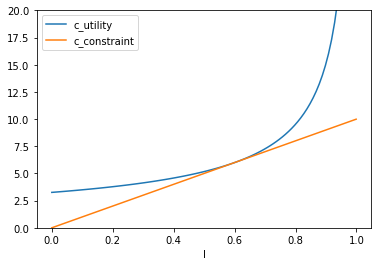

In [71]:
ax_ = df_5.plot('l','c_utility')       # 1
df_5.plot('l','c_constraint', ax=ax_)  # 2
ax_.set_ylim([0,20])                   # 3
pass

```{admonition} コードの説明
:class: dropdown

1. プロットの軸を`ax_`に割り当てている。
2. 制約式のずを同じ軸に表示するために引数`ax=ax_`を使い、軸を`ax_`に指定している。
3. `set_ylim()`は軸`ax_`のメソッドであり、縦軸の表示範囲を指定する。
```

## 最適化問題：２変数の場合

### 説明

２変数の場合は`minimize`関数を使う。様々な引数が用意されているが、基本的には次のようなコードの書き方となる。

```
minimize(f, x0, bounds=(a,b), constraints)
```
* `f`は最小化したい関数名
    * `f(x)`のように引数は`x`１つで書く必要があり、`x`を`array`と理解すれば良いだろう（例を参照）。
* `bounds`（指定しなくても良い）は関数を最大化する`x`の値を探す区間を指定する引数である。
    * `a`は区間の最小値、`b`は区間の最大値を指し、次のように設定する。
        ```
        [(変数１の最小値, 変数１の最大値), (変数２の最小値, 変数２の最大値)]
        ```
    * 指定しない箇所は`None`とする。例えば、非負の値に限定したい場合は`[(0,None),(0,None)]`とする。
    * 裏でBrent法が使われており、関数を最小化する`x`の探索は`bounds`で指定した区間に限られる。
* `constraints`（指定しなくても良い）は制約式。
    * １つの制約式を１つの辞書として設定する。また制約式が複数ある場合は、それぞれに辞書を作成し、複数の辞書からなるリストもしくはタプルとして設定する。
    * 詳細は例３と例４を参照

＜２つの注意点＞
1. 返り値は、関数を最小化るる変数の値だけではなく、様々な情報が整理されたオブジェクトとして返される。
1. 最大化のための関数は用意されていない。従って、最大化した関数にマイナスの符号をつけて`minimize()`関数を評価する必要がある。

### 例１

次の最小化問題を考えよう。

$$
\min_{y,z}\; y^2+2zy+z^2+10
$$

まず関数を定義するが、次の点に留意すること。
* `f_ex3`の引数`x`を`array`として考える。
* `x`の第0要素を`y`とし、第1要素を`z`とする。
* 次のようなイメージ
    ```
    x = np.array(y,z)
    ```

In [72]:
def f_ex3(x):   # 1
    y = x[0]    # 2
    z = x[1]    # 3
    return y**2 + y*z + z**2 + 10  # 4

```{admonition} コードの説明
:class: dropdown

1. 関数`f_ex3`の引数`x`を`array`と想定する。
2. `x`の第0要素を`y`に割り当てる。
3. `x`の第1要素を`z`に割り当てる。
4. 最大化する関数を返す。
```

次に解探索の初期値を設定しよう。

In [73]:
x0 = [0.3, 0.5]

`x0`の第0要素は`y`の初期値、第1要素は`z`の初期値となる。これは関数`f_ex3`の引数である`x`の要素の順番に対応している。

In [74]:
res3 = op.minimize(f_ex3, x0=x0)
res3

      fun: 10.000000000001792
 hess_inv: array([[ 0.66873401, -0.33559015],
       [-0.33559015,  0.66913043]])
      jac: array([-1.07288361e-06,  1.54972076e-06])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([-1.26041337e-06,  1.40562889e-06])

この返り値の中で重要なのは次の４つである。
* `fun`（１行目）：最小化された場合の関数の値
* `message`（５行目）:「最適化は成功した」というメッセージ
* `success`（最後から２行目）：計算が成功したかどうかを示すブール値。
    * `True`：計算成功
    * `False`：計算失敗
* `x`（最後）：関数を最小化する変数の値
    * 第0要素は`y`の値、第1要素は`z`の値

それぞれは次のように属性としてアクセスできる。

In [75]:
res3.fun

10.000000000001792

In [76]:
res3.message

'Optimization terminated successfully.'

In [77]:
res3.success

True

In [78]:
res3.x

array([-1.26041337e-06,  1.40562889e-06])

### 例２

次の最大化問題を考えよう。

$$
\max_{y,z}\; -z^2-y^2+zy+z+y
$$

まず関数を定義するが，例１と同様に次の点に要注意。
* `f_ex4`の引数`x`は`array`として考える。
* `x`の第0要素を`y`とし、第1要素を`z`とする。
* 次のようなイメージ
    ```
    x = np.array(y,z)
    ```
* 返り値にマイナスの符号が追加されている。

In [79]:
def f_ex4(x):
    y = x[0]
    z = x[1]
    return -( -z**2-y**2+z*y+z+y )

次に解探索の初期値を設定する。

In [80]:
x0 = [0.5, 0.5]

解探索の初期値として`[0.5, 0.5]`を設定し計算する。

In [81]:
res4 = op.minimize(f_ex4, x0=[0.5, 0.5])
res4

      fun: -0.9999999999999998
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([0.99999999, 0.99999999])

### 例３

ここでは制約付き最大化問題を考える。次の制約のもとで例２の`f_ex4`を最大化するとしよう。

$$
y+z=1
$$

制約式の導入を４つのステップに分けて説明する。

**＜ステップ１＞**<br>
制約式を捉えるコード書くために、左辺が非負となるように書き換える。

$$
y+z-1=0
$$

**＜ステップ２＞**<br>
この式の左辺が返り値となる関数を定義する。

In [82]:
def f_const(x):
    y = x[0]
    z = x[1]
    return x[0]+x[1]-1

ここでも引数`x`は`array`と想定しており，第0要素を`y`に，第1要素を`z`に割り当てている。

**＜ステップ３＞**<br>
この関数を使い次のように引数`constraints`に設定する変数を作成する。

In [83]:
const = {'type':'eq', 'fun': f_const}

右辺は辞書となっており、キーと値の２つのペアがある。
* `type`：制約式のタイプを指定するキー。
    * `eq`：制約式が等号の場合。
    * `ineq`：制約式が不等号の場合。    
* `fun`：制約式を指定するキー。
    * `f_const`：制約式の関数名
    
**＜ステップ４＞**<br>
引数`constraints`に変数`const`を指定し計算する（初期値を`[5.0, 0.6]`とする）。

In [84]:
res5 = op.minimize(f_ex4, x0=[5.0, 0.6], constraints=const)
res5

     fun: -0.7499999999999016
     jac: array([-0.50000054, -0.49999945])
 message: 'Optimization terminated successfully'
    nfev: 13
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.49999982, 0.50000018])

In [85]:
print(f'yは{res5.x[0]:.1f}であり、zは{res5.x[1]:.1f}です。')

yは0.5であり、zは0.5です。


`y`の値と`z`の値は制約式を満たすことがわかる。また制約式がない場合と比べて、`y`の値と`z`の値は異なり、最大化された関数の値も異なる。

In [86]:
print(f'制約式がない場合の関数の最大値は{-res4.fun:.2f}であり、制約がある場合は{-res5.fun:.2f}となる。')

制約式がない場合の関数の最大値は1.00であり、制約がある場合は0.75となる。


### 例４

制約が不等式の場合を簡単に説明する。例３の制約式を

$$
y+z\leq 1
$$

としよう。

**＜ステップ１＞**<br>
左辺が非負になるように書き換えると

$$
1-y-z\geq 0
$$

となる。

**＜ステップ２＞**<br>
この不等式の左辺を制約式としてコードを書くが、上の`f_const`と異なることがわかる。

In [87]:
def f_const_ineq(x):
    y = x[0]
    z = x[1]
    return 1-x[0]-x[1]

**＜ステップ３＞**<br>
この場合の引数`constraint`に使う辞書は次のようになる。

In [88]:
const_ineq = {'type':'ineq', 'fun': f_const_ineq}

`const`との違いは、キー`type`に対応する値が`ineq`になっており、`fun`には`f_const_ineq`が指定されている。

**＜ステップ４＞**<br>
計算すると同じ結果になることが確認できる。

In [89]:
op.minimize(f_ex4, x0=[5.0, 0.6], constraints=const_ineq)

     fun: -0.7499999999999043
     jac: array([-0.50000052, -0.49999944])
 message: 'Optimization terminated successfully'
    nfev: 13
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.49999982, 0.50000018])

当たり前だが例３の解と同じになっている。

### 労働供給問題

労働供給問題を再考する。まず効用関数を設定し直そう。

In [90]:
def u(x):
    c = x[0]
    l = x[1]
    return -( a*np.log(c)+(1-a)*np.log(1-l) )

次に制約式[](eq:scipy-pcwl)だが、下のように書き換えることができる。

$$
pc=wl
\quad
\Rightarrow
\quad
wl-pc=0
$$

これを使い制約式を定義する。

In [91]:
def budget(x):
    c = x[0]
    l = x[1]
    return w*x[1]-p*x[0]

引数`constraint`に使う辞書は次のように書くことができる。

In [92]:
const = {'type':'eq', 'fun': budget}

また経済理論から次のことが明らかである。
* `c`は非負
* `l`は0と1の間にある

この情報を引数`bounds`に設定するが、次のような書き方となる。
```
[(cの最小値、cの最大値), (lの最小値、lの最大値)]
```
ここで`c`と`l`の順番は関数`budget`の引数`x`に対応しており，それぞれの要素の値は
* `c`の最小値：0
* `c`の最大値：$w/p$
* `l`の最小値：0
* `l`の最大値：1

となる。これらの値を使い引数`bounds`に設定する値を次のようにする。

In [93]:
bnds = [(0,w/p),(0,1)]

In [94]:
# 初期値
x0 = [4.0, 0.3]

# 計算
op.minimize(u, x0, bounds=bnds, constraints=const)

     fun: -0.7085392478935648
     jac: array([-0.09995668,  1.00065053])
 message: 'Optimization terminated successfully'
    nfev: 18
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([6.00260037, 0.60026004])

`minimize_scalar()`で解いた値と同じであることが確認できる。

### 練習問題

予算制約式が不等号の場合の労働供給問題を解きなさい。